In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

In [3]:
groq_api_key = os.getenv("GROQ_API_KEY")
model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [4]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

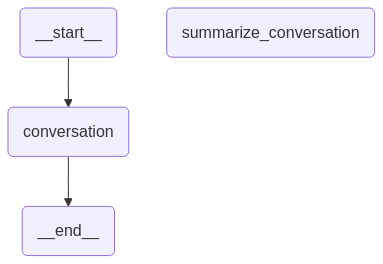

In [5]:
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### **Streaming full state**

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [6]:
config = {
    'configurable': {
        'thread_id': "chat_1"
    }
}

In [7]:
## Start conversion
for chunk in graph.stream(
    {
        "messages": [HumanMessage(content="Assalamualikum, I'm Al amin and recently completed my undergraduate")]
    },
    config=config,
    stream_mode="updates"
):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Wa Alaikumussalam Al Amin!\n\nCongratulations on completing your undergraduate studies! That's a significant achievement, and I'm sure you must be feeling proud and accomplished.\n\nWhat's your field of study, if you don't mind me asking? And what are your plans now that you've completed your undergraduate degree? Do you have any plans for further education or are you entering the workforce?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 23, 'total_tokens': 96, 'completion_time': 0.145660904, 'prompt_time': 0.002451178, 'queue_time': 0.044400202, 'total_time': 0.148112082}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--31218de9-b0ac-4bfb-a093-5e76e3bb9e7e-0', usage_metadata={'input_tokens': 23, 'output_tokens': 73, 'total_tokens': 96})}}


In [8]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Assalamualikum, I'm Al amin and recently completed my undergraduate")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Wa Alaikumussalam Al Amin!

Congratulations again on completing your undergraduate studies! That's a huge milestone.

How are you feeling now that you've finished your degree? Are you planning to pursue a master's degree, or are you looking to start your career? What are your interests and goals, and how can I assist you?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [9]:
config = {
    'configurable': {
        'thread_id': "chat_2"
    }
}

input_message = HumanMessage(content="Assalamualikum, I'm Al amin and recently completed my undergraduate")
for event in graph.stream({"messages": [input_message]}, config=config, stream_mode='values'):
    for m in event['messages']:
        m.pretty_print()
    print("---"*26)

================================ Human Message =================================

Assalamualikum, I'm Al amin and recently completed my undergraduate
------------------------------------------------------------------------------
================================ Human Message =================================

Assalamualikum, I'm Al amin and recently completed my undergraduate
================================== Ai Message ==================================

Wa Alaikumussalam Al Amin!

Mabrook on completing your undergraduate degree! That's a significant achievement. How do you feel now that you've finished this chapter of your life?

What field did you major in, if you don't mind me asking? And do you have any plans or goals for your future, whether it's further education or entering the workforce? I'm here to listen and help in any way I can.
------------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [ ]:
config = {
    'configurable': {
        'thread_id': "chat_3"
    }
}
input_message = HumanMessage(content="Assalamualikum, I'm Al amin and recently completed my undergraduate")

async for event in graph.astream_events({"messages": [input_message]}, config=config, version='v2'):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conver

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [15]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "caht_5"}}
input_message = HumanMessage(content="Tell me about future Ai and why its important to learning!.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content=' future', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content=' AI', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content=' exciting', additional_kwargs={}, response_metadata={}, id='run--94815156-5b24-4a3e-9c2e-8fa43e901c62')}
{'chunk': AIMessageChunk(content=' and', additional_kwargs={},

As we see above, just use the `chunk` key to get the `AIMessagesChunk`

In [16]:
config = {"configurable": {"thread_id": "6"}}
input_message = HumanMessage(content="Tell me about future Ai and why its important to learning!.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|**|The| Future| of| AI| and| Why| Learning| About| It| Matters|**

|The| future| of| Artificial| Intelligence| (|AI|)| is| rapidly| unfolding|,| and| it's| essential| to| understand| its| potential| impact| on| various| aspects| of| our| lives|.| In| this| response|,| we'll| explore| the| future| of| AI|,| its| importance| in| learning|,| and| provide| guidance| on| how| to| get| started|.

|**|The| Future| of| AI|:| Trends| and| Predictions|**

|The| field| of| AI| is| expected| to| continue| growing|,| with| significant| advancements| in| areas| like|:

|*| **|Deep| Learning|**:| AI| systems| will| become| more| sophisticated|,| enabling| applications| like| autonomous| driving|,| personalized| medicine|,| and| intelligent| homes|.
|*| **|Edge| AI|**:| AI| will| be| integrated| into| edge| devices|,| such| as| smartphones|,| smart| home| devices|,| and| wear|ables|,| making| AI| more| accessible| and| ubiquitous|.
|*| **|Explain|able| AI| (|X|AI|)|**:| There| will| be| a| growing| n

In [18]:
config = {"configurable": {"thread_id": "6"}}
input_message = HumanMessage(content="if i do not learn it so what will be happened?")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="")

**A Continuum of Consequences: Understanding the Impact of Not Learning About AI**

Not learning about AI can have a range of consequences, from mild to severe. Here's a more detailed look at what might happen:

**Mild Consequences**

* **Staying Behind in Your Career**: You might not be able to take advantage of new career opportunities or advancements in your field that rely on AI.
* **Limited Personal Projects**: You might not be able to leverage AI-powered tools and technologies to enhance your personal projects or hobbies.
* **Missing Out on AI-Driven Innovations**: You might not be aware of or benefit from AI-driven innovations that could improve your daily life, such as:
	+ Smart home automation
	+ Personalized healthcare and wellness
	+ Intelligent transportation systems

**Moderate Consequences**

* **Job Insecurity**: As AI becomes more prevalent, you might face increased job insecurity or reduced opportunities for career advancement.
* **Difficulty Adapting to New Technologi